In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = pd.read_csv('../data/it-data-4metrics.csv', sep=',')
dataframe = dataframe.iloc[:,0:4]

In [2]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in dataframe.index:
    if dataframe['metric_name'][indx] not in dic_name.keys():
        dic_name[dataframe['metric_name'][indx]] = []
    if dataframe['metric_id'][indx] not in dic_name[dataframe['metric_name'][indx]]:
        dic_name[dataframe['metric_name'][indx]].append(dataframe['metric_id'][indx])
        dic_id[dataframe['metric_id'][indx]] = [dataframe['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

In [3]:
sample = len(keys_id)
look_back = 10
supr=[]
for i in range(sample):
    indx = keys_id[i]
    indexNames = dataframe[ dataframe['metric_id'] == indx ].index
    data = dataframe.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
    dataset = data.values
    dataset = dataset.astype('float32')
    dic_id[indx].append(dataset)
    dataset = dataset.reshape(-1, 1)
    
    if len(dataset) > look_back*4:
        # split into train and test sets
        train_size = int(len(dataset) * 0.67)
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

        # reshape into X=t and Y=t+1
        look_back = 10
        x_train, y_train = create_dataset(train, look_back)
        x_valid, y_valid = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))

        # create and fit the SimpleRNN network
        model = Sequential()
        model.add(SimpleRNN(32, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        start_fit = time.time()
        history = model.fit(x_train, y_train, epochs=100, batch_size=look_back, verbose=0, validation_data=(x_valid, y_valid))
        end_fit = time.time()

        # make predictions
        y_pred_train = model.predict(x_train)
        start_pred = time.time()
        y_pred_valid = model.predict(x_valid)
        end_pred = time.time()

        # calculate root mean squared error
        testScore = math.sqrt(mean_squared_error(y_valid, y_pred_valid[:,0]))

        dic_id[indx].append(testScore)
        dic_id[indx].append([x_train, y_train, y_pred_train])
        dic_id[indx].append([x_valid, y_valid, y_pred_valid])
        dic_id[indx].append(end_fit - start_fit)
        dic_id[indx].append(end_pred - start_pred)
    else:
        supr.append(indx)
        dic_name[dic_id[indx][0]].remove(indx)
    if (i+1) % 25 == 0:
        print("%.2f" % ((100/sample)*(i+1)),"% completed...")
for i in supr:
    dic_id.pop(i)

9.88 % completed...
19.76 % completed...
29.64 % completed...
39.53 % completed...
49.41 % completed...
59.29 % completed...
69.17 % completed...
79.05 % completed...
88.93 % completed...
98.81 % completed...


In [4]:
if sample == len(keys_id):
    pd.DataFrame(dic_id).to_csv('RNN_bis.csv', encoding='utf-8')

<ipython-input-5-128b62db2340>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


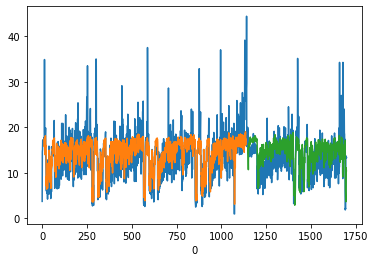

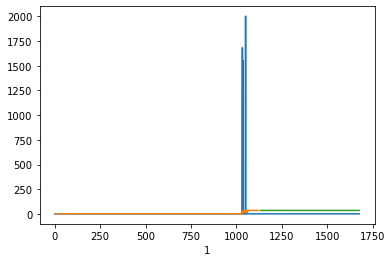

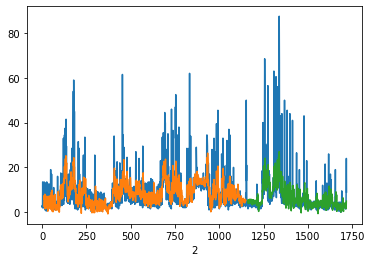

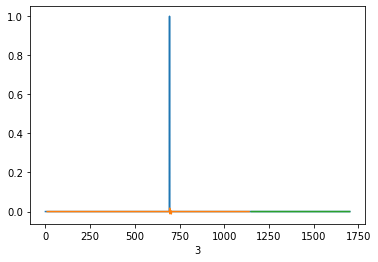

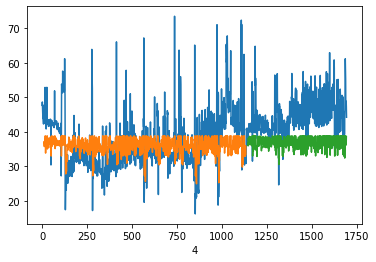

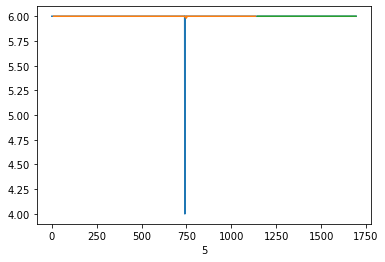

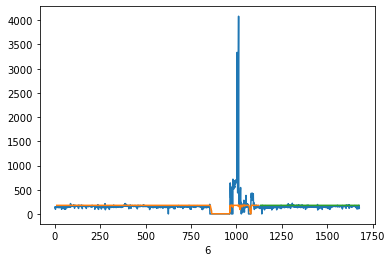

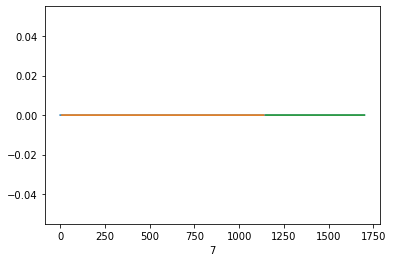

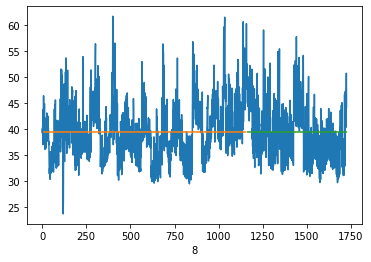

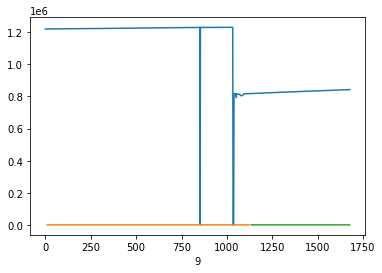

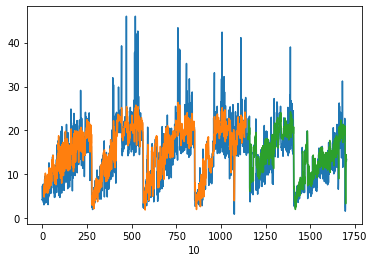

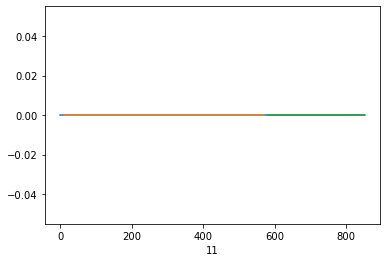

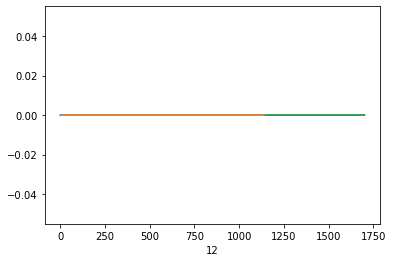

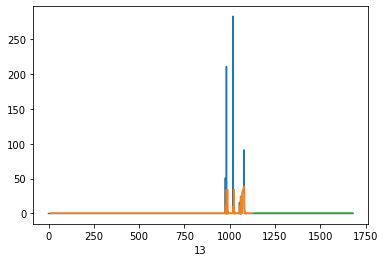

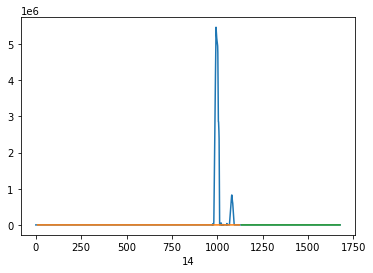

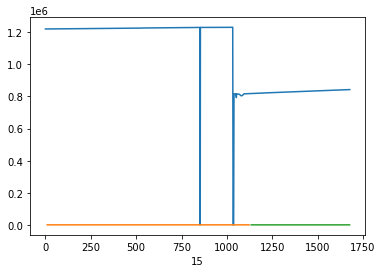

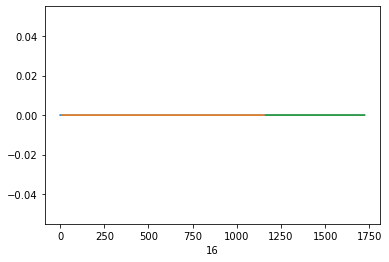

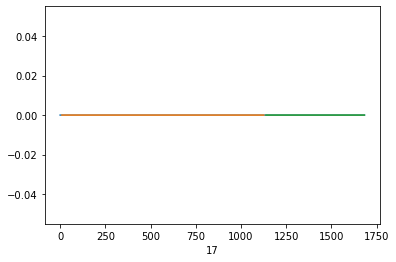

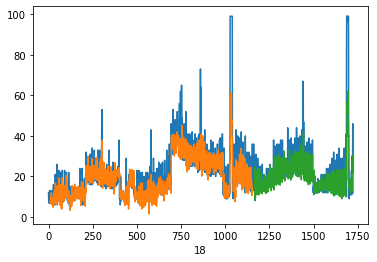

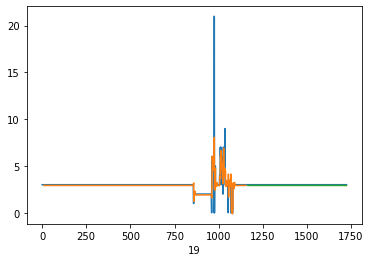

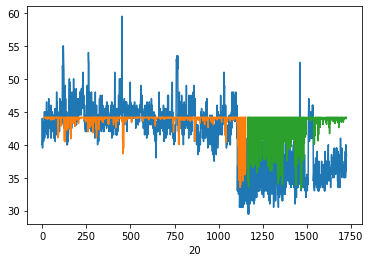

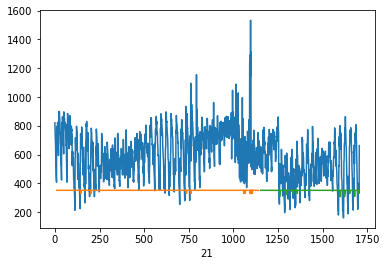

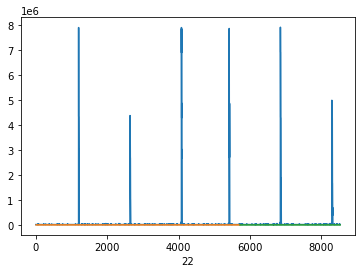

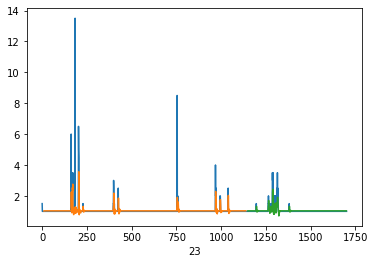

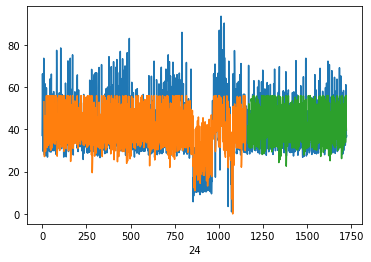

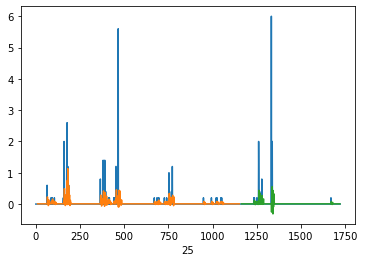

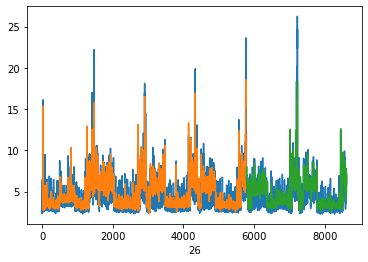

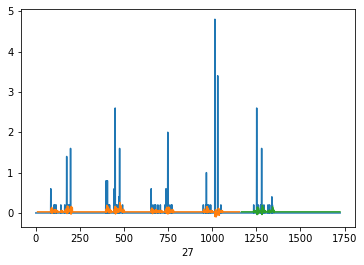

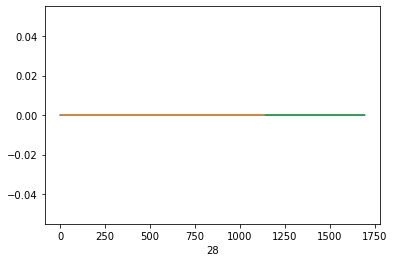

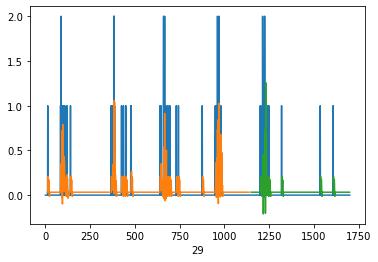

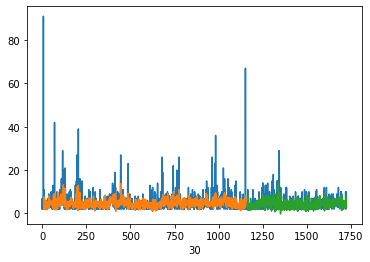

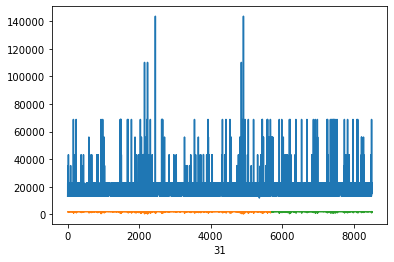

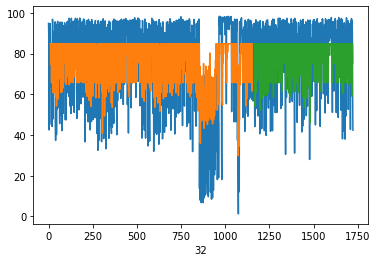

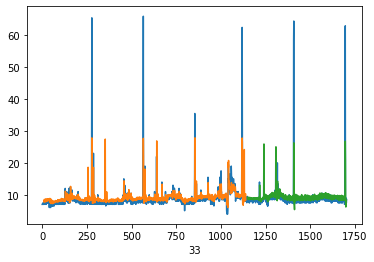

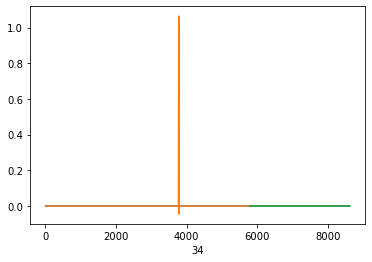

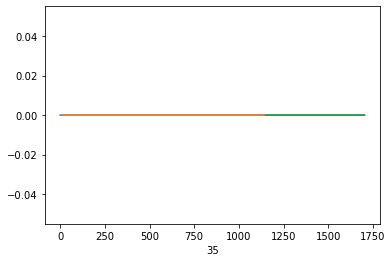

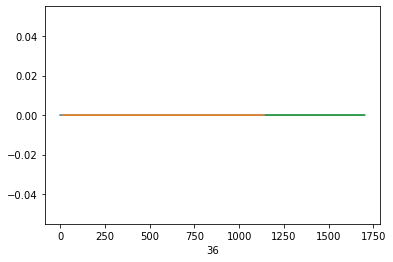

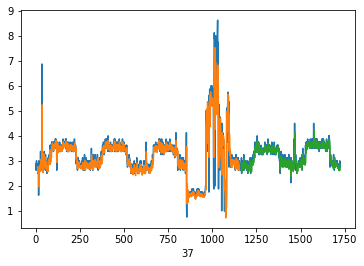

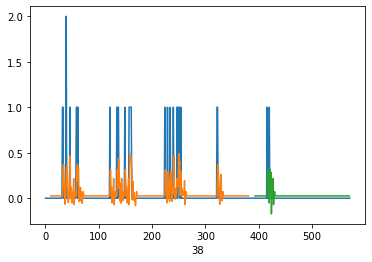

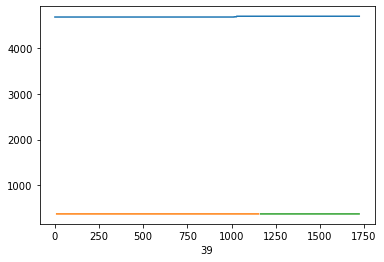

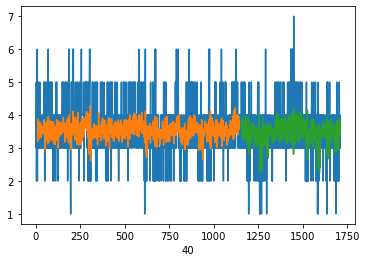

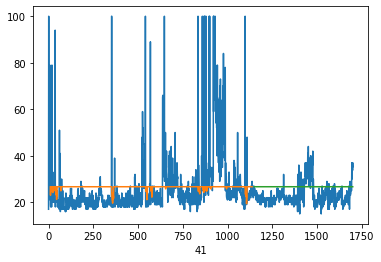

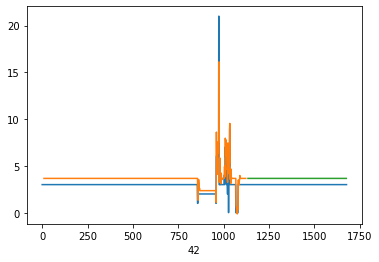

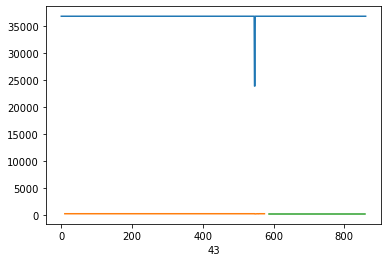

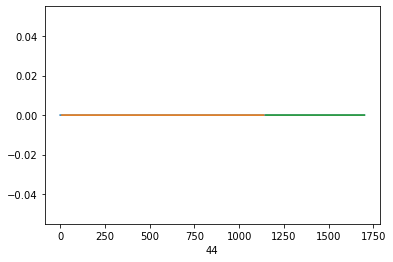

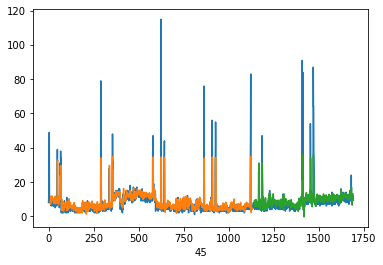

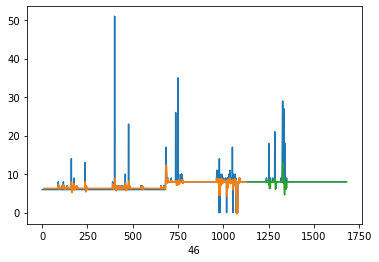

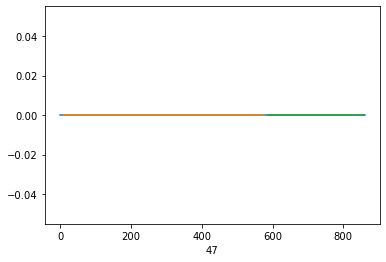

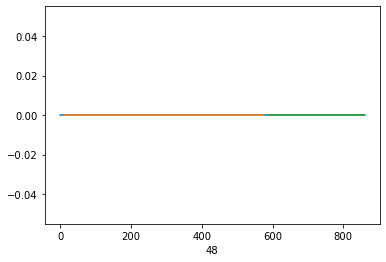

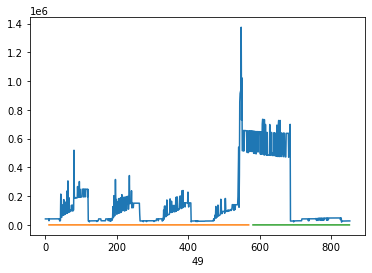

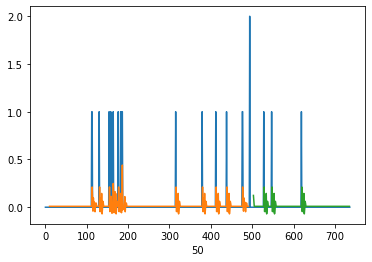

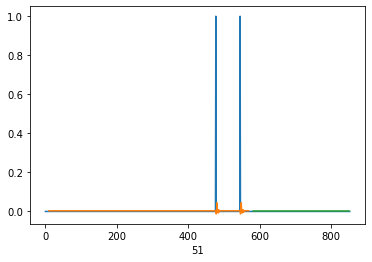

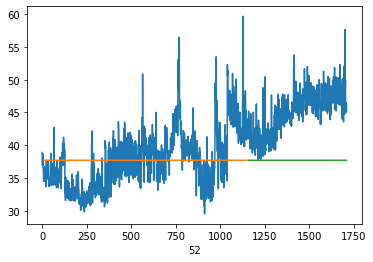

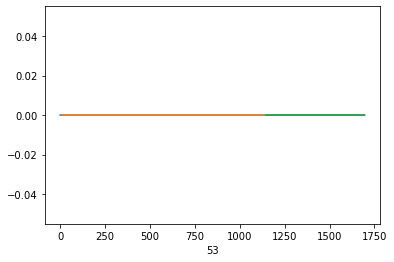

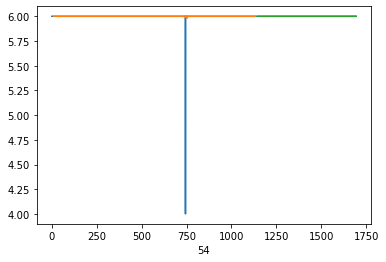

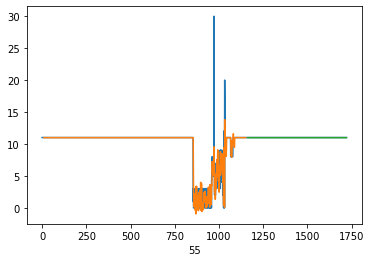

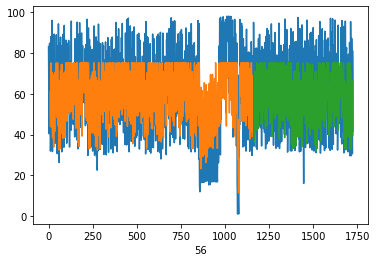

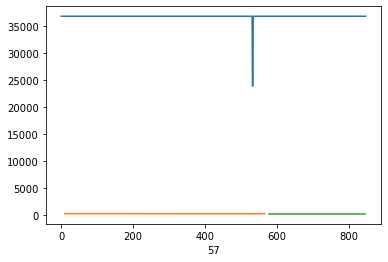

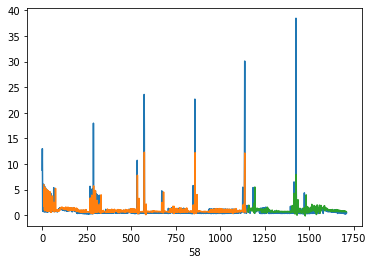

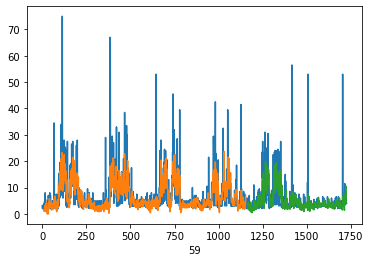

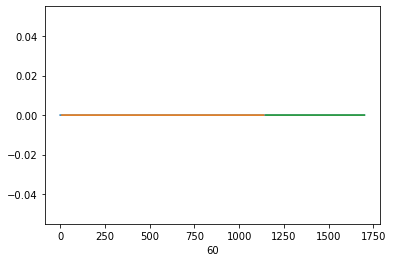

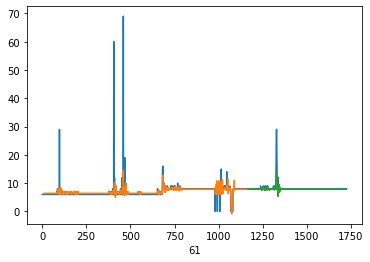

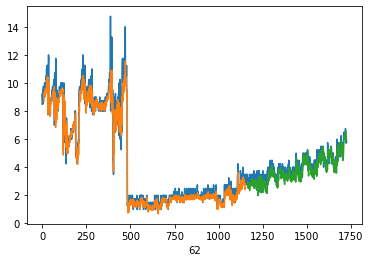

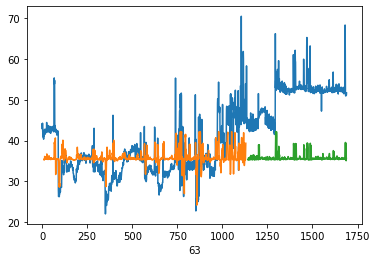

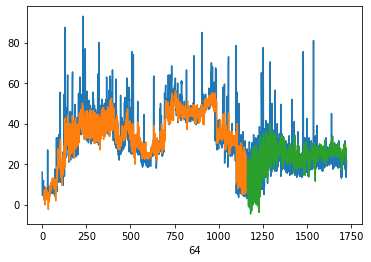

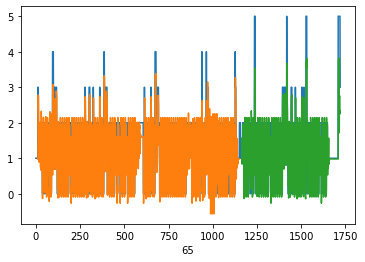

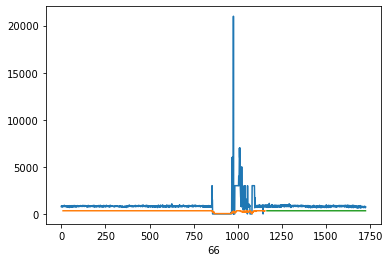

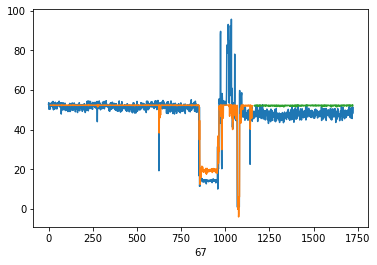

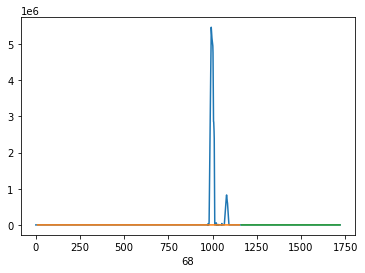

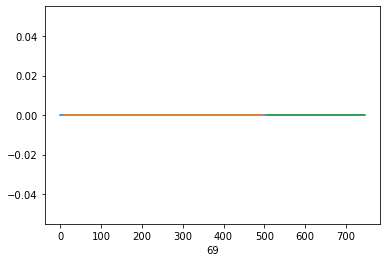

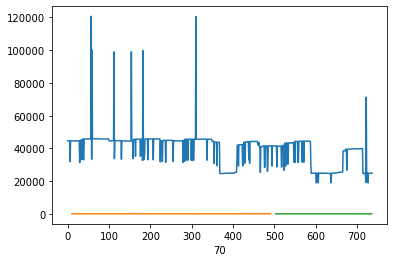

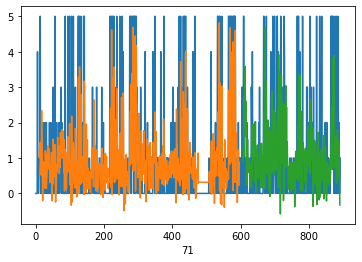

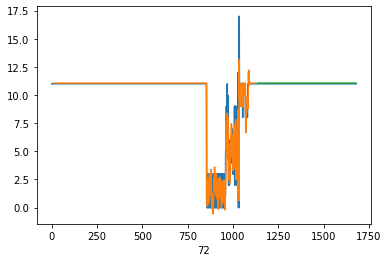

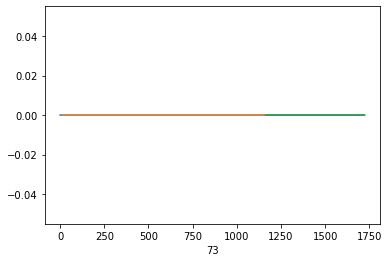

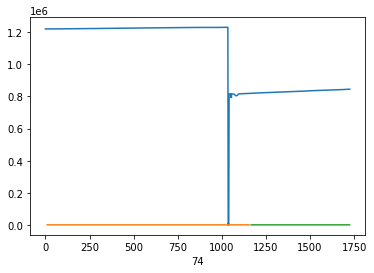

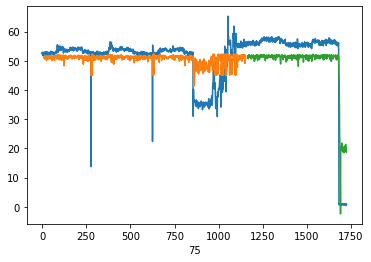

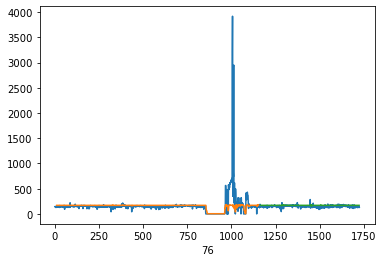

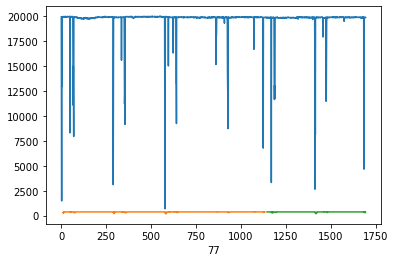

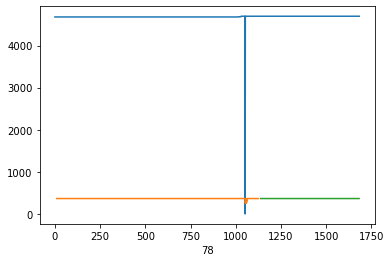

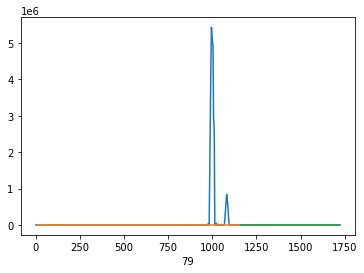

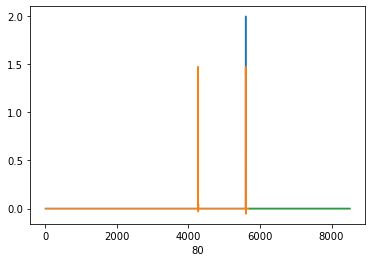

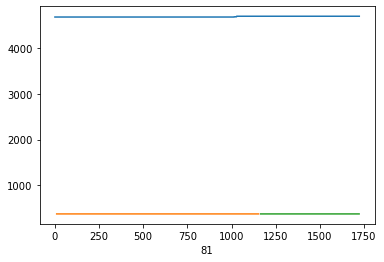

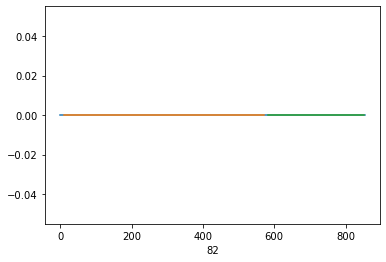

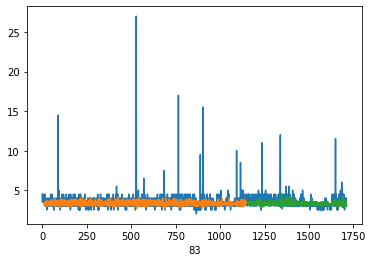

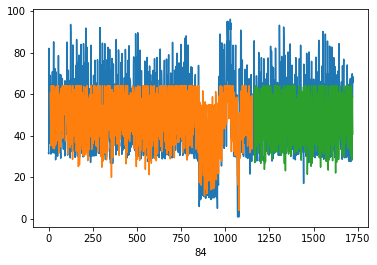

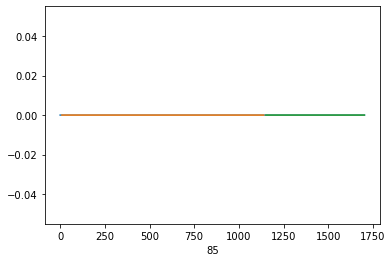

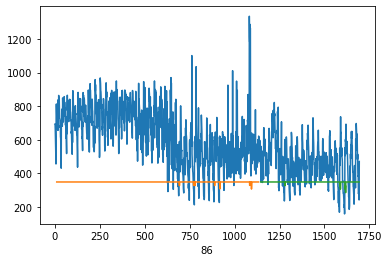

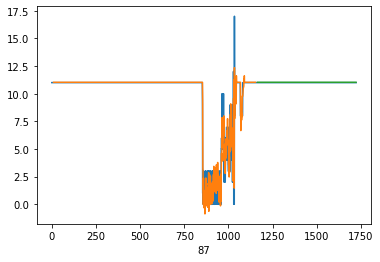

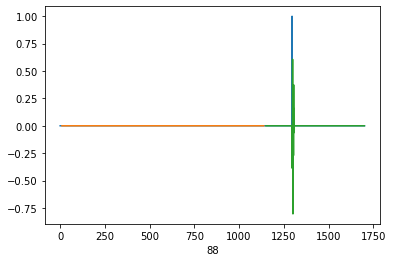

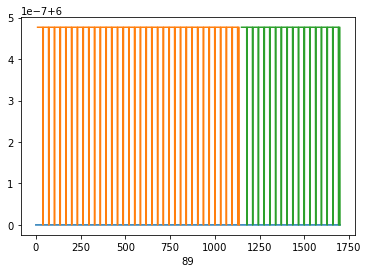

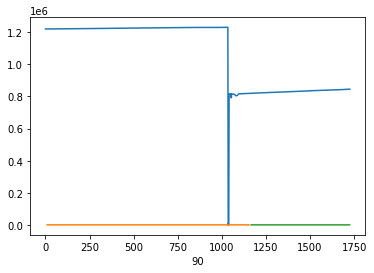

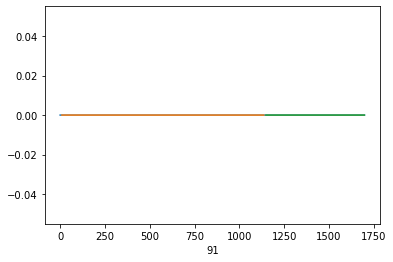

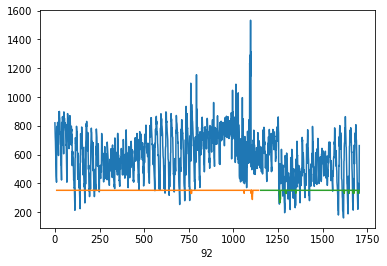

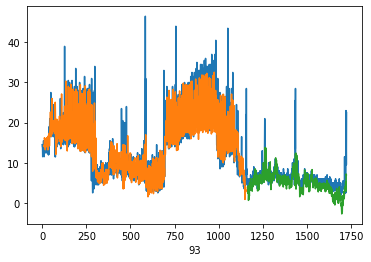

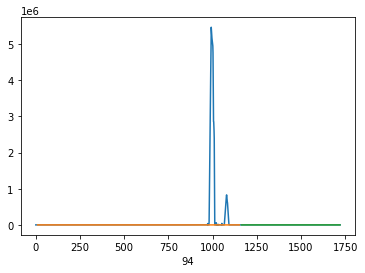

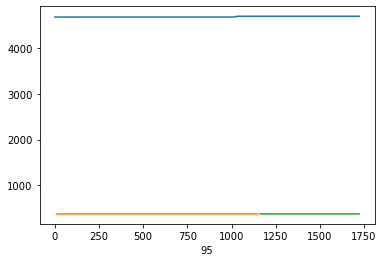

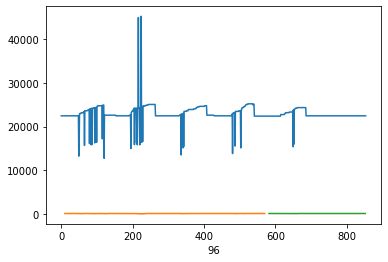

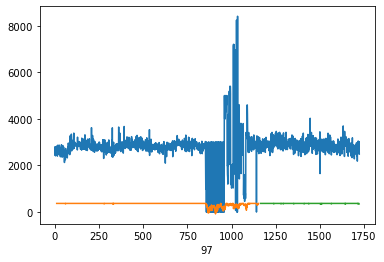

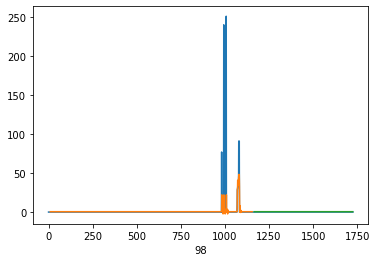

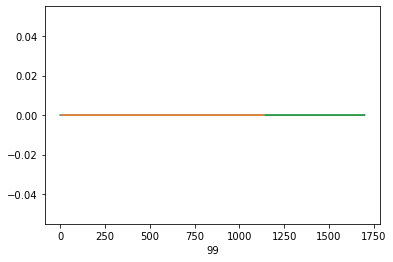

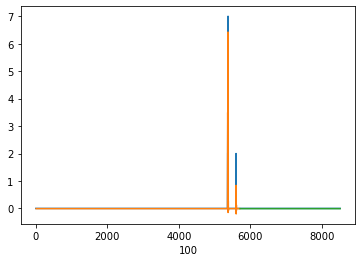

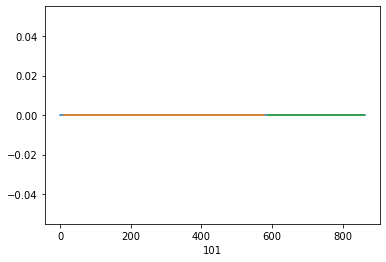

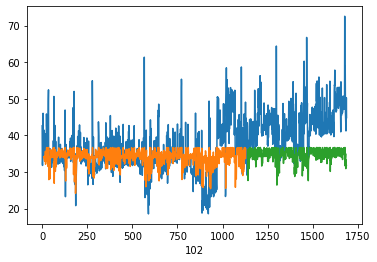

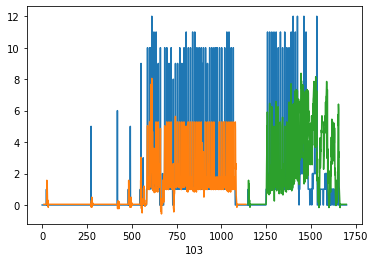

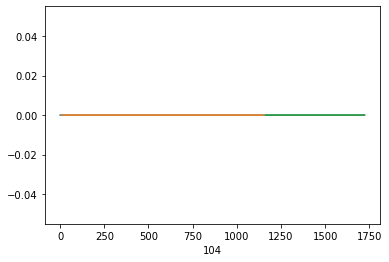

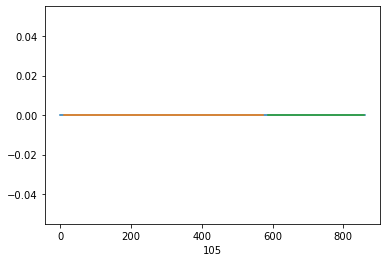

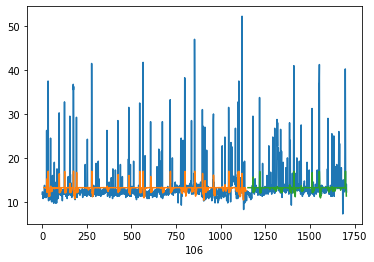

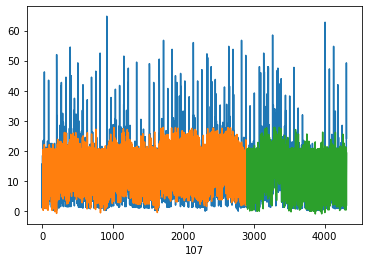

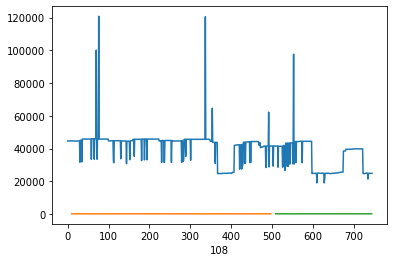

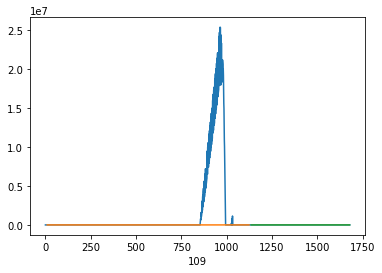

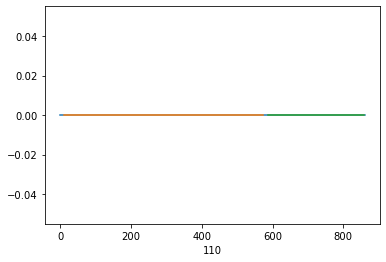

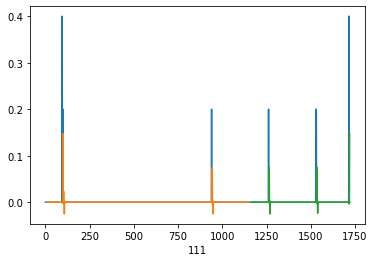

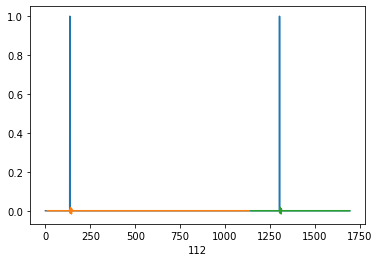

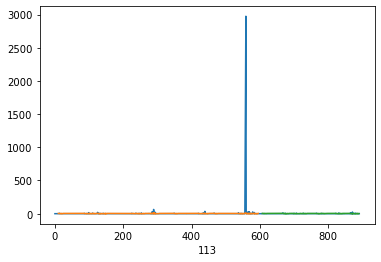

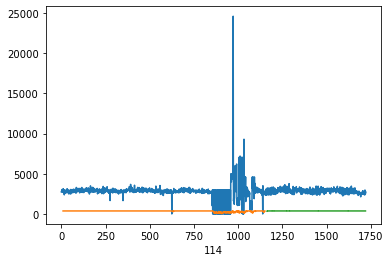

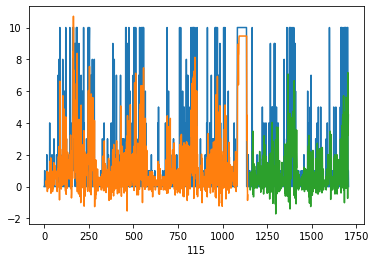

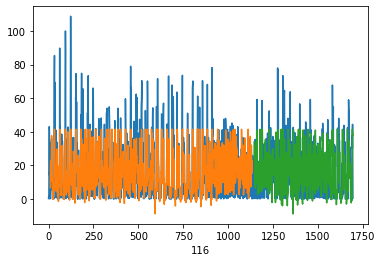

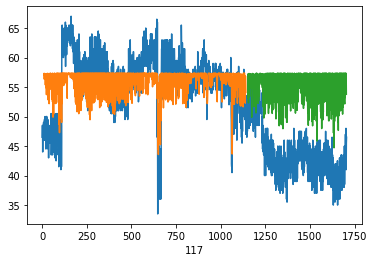

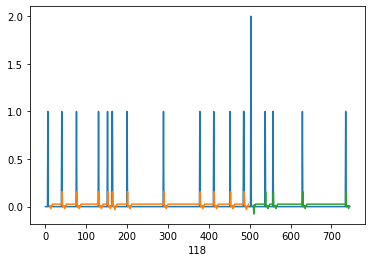

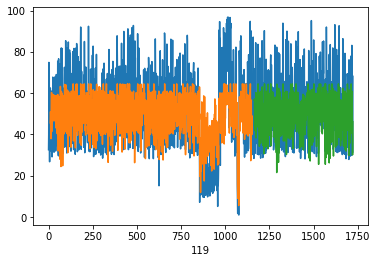

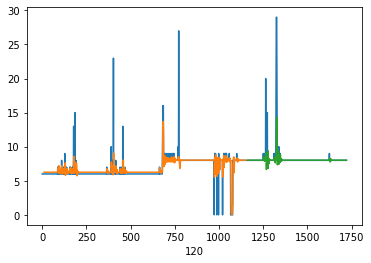

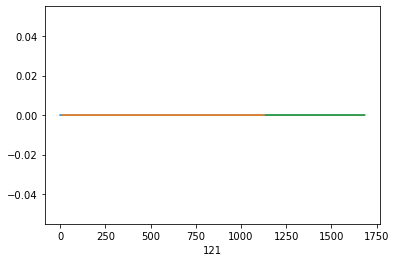

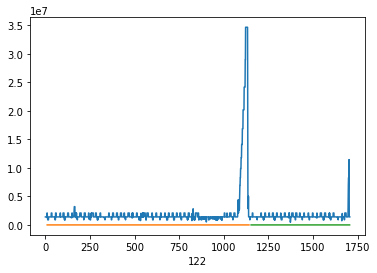

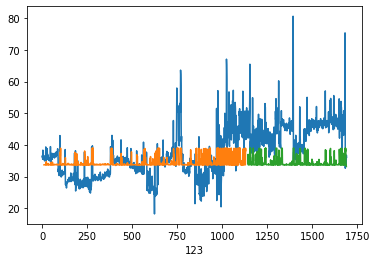

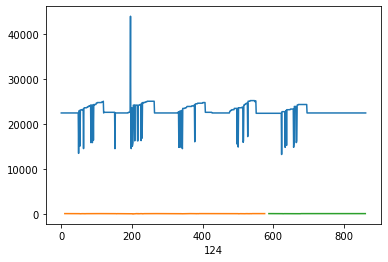

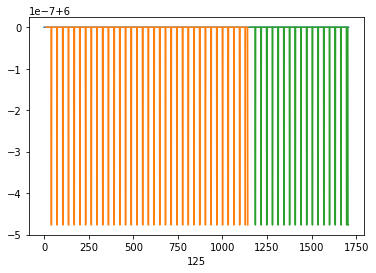

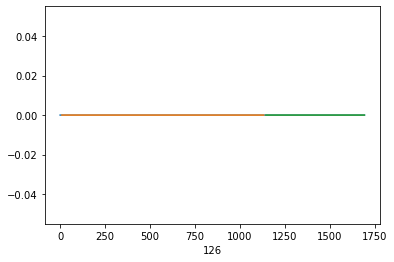

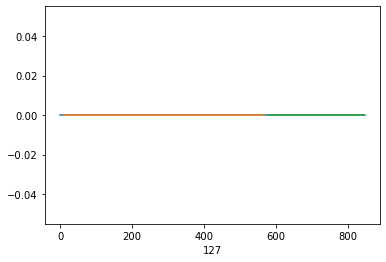

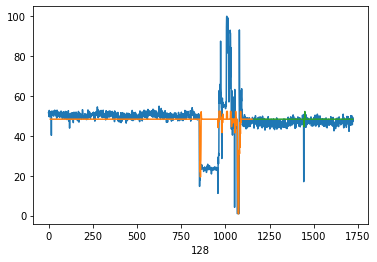

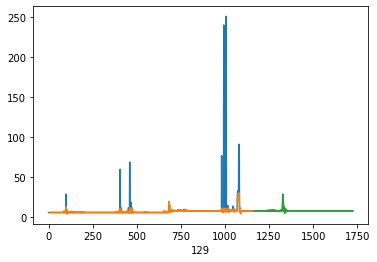

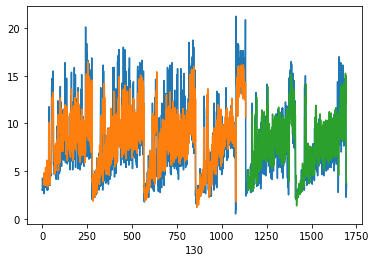

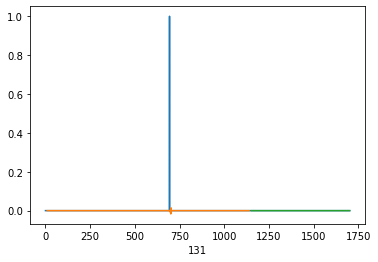

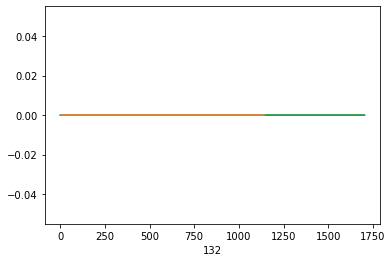

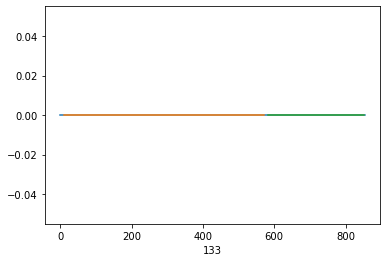

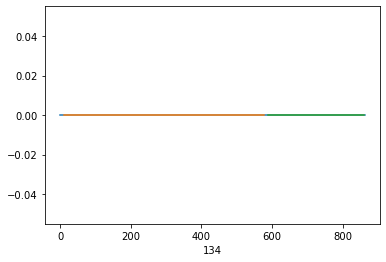

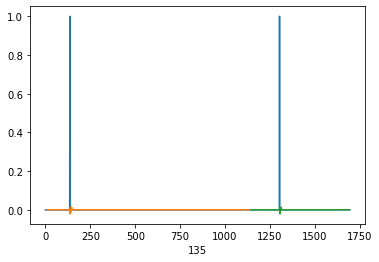

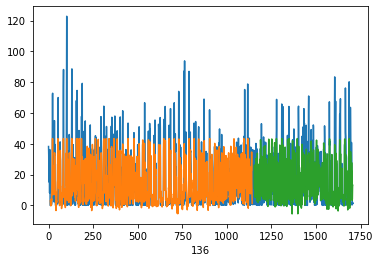

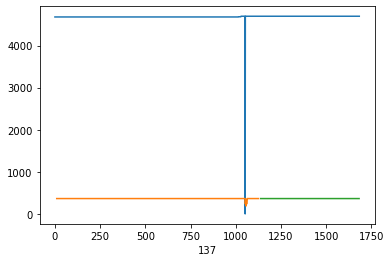

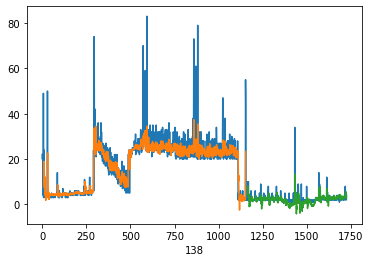

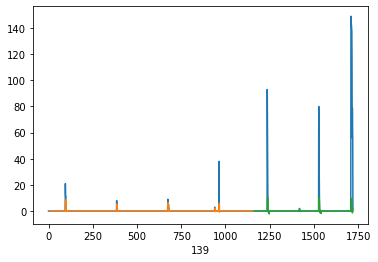

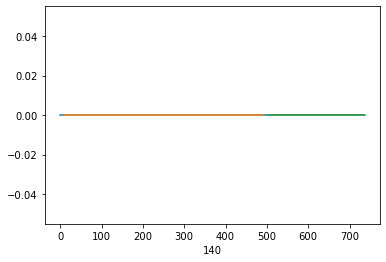

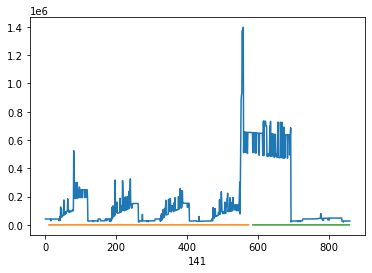

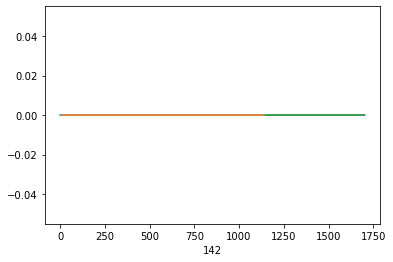

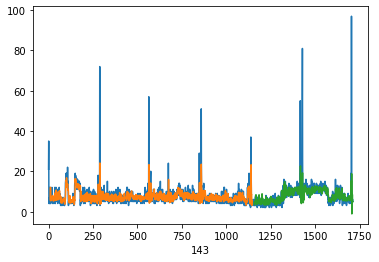

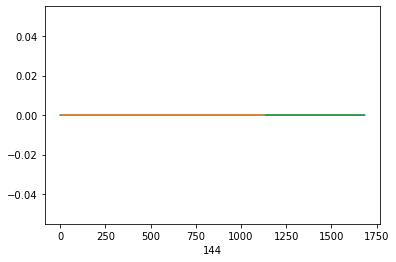

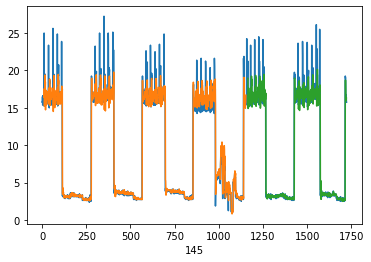

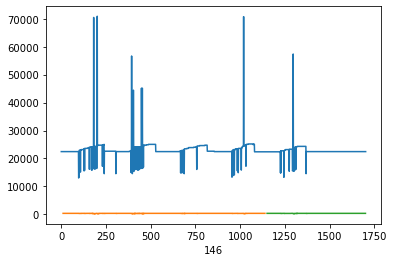

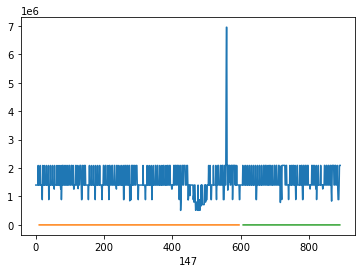

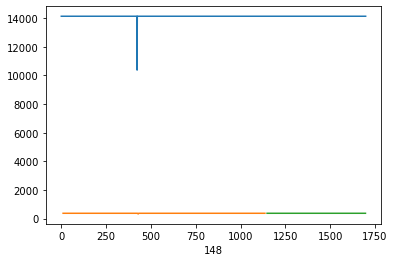

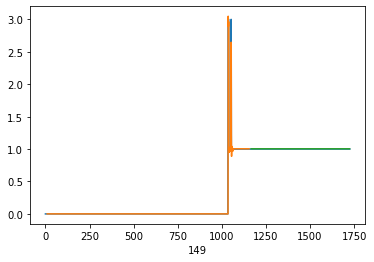

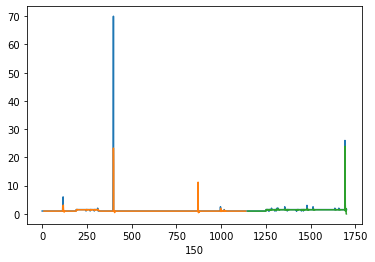

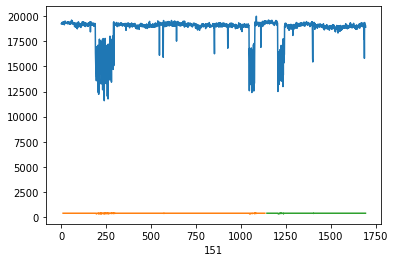

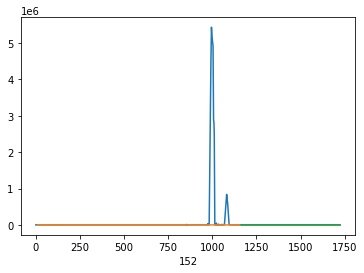

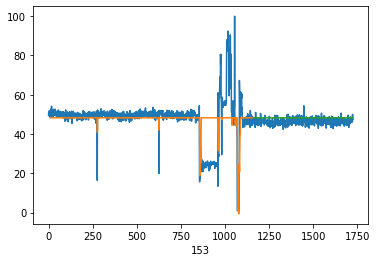

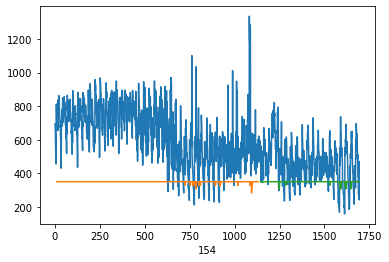

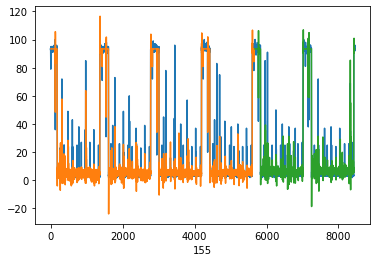

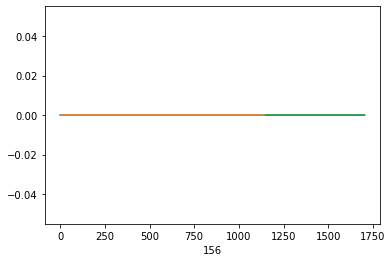

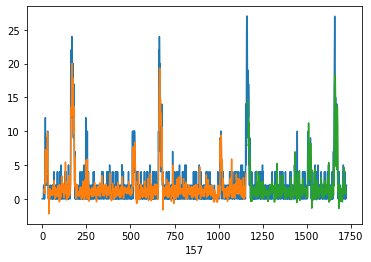

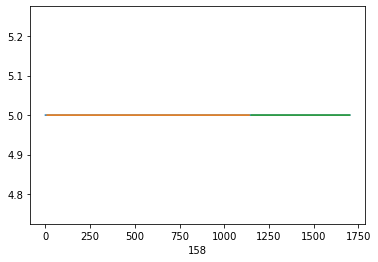

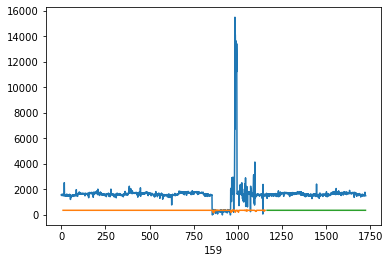

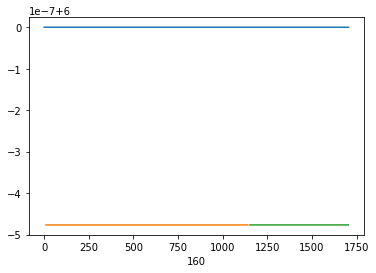

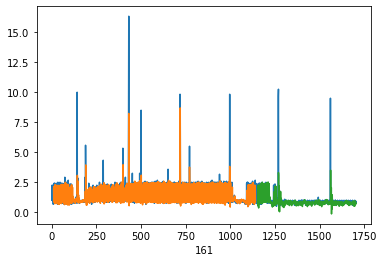

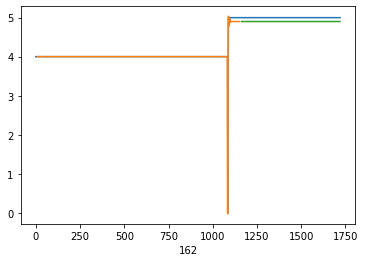

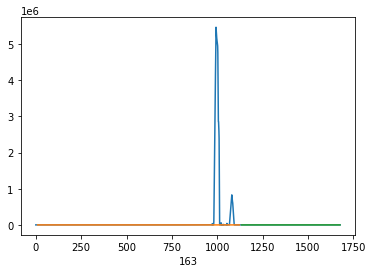

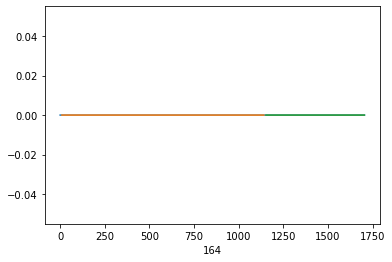

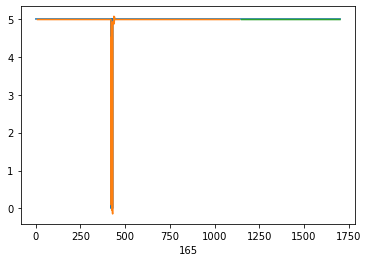

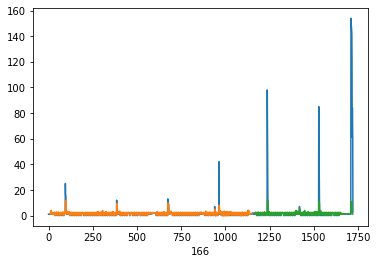

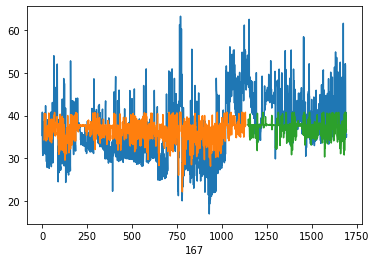

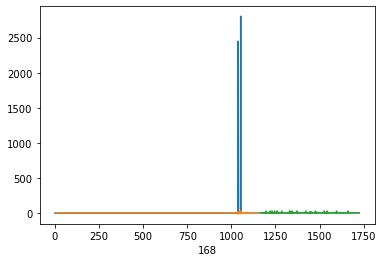

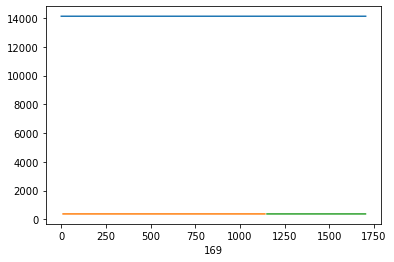

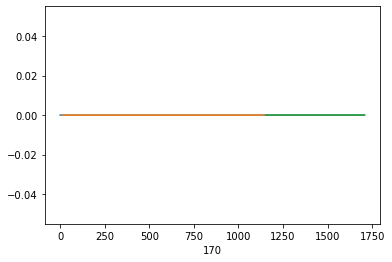

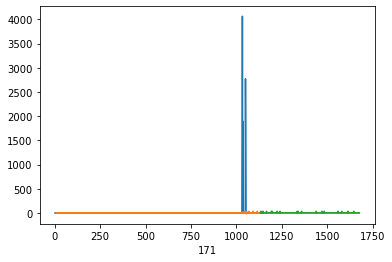

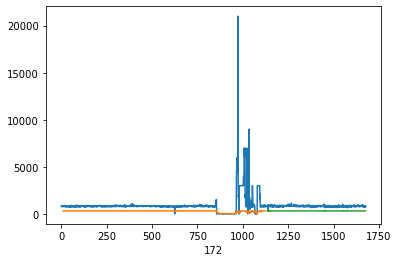

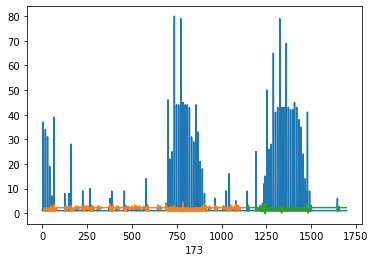

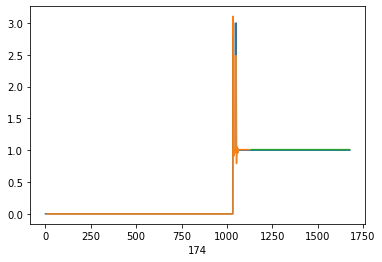

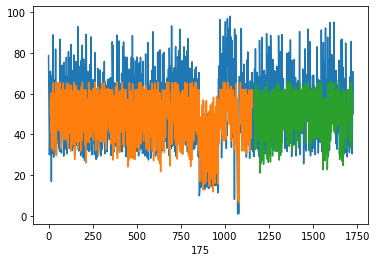

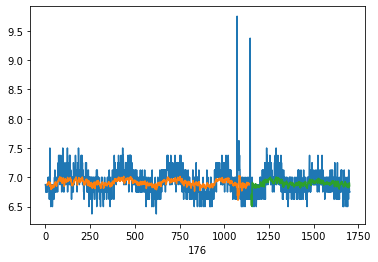

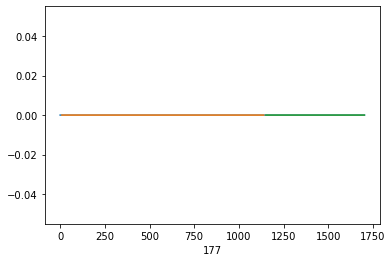

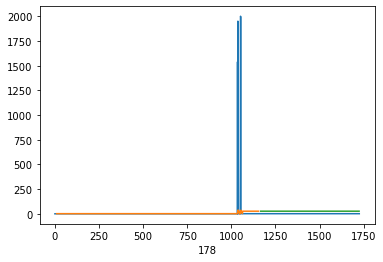

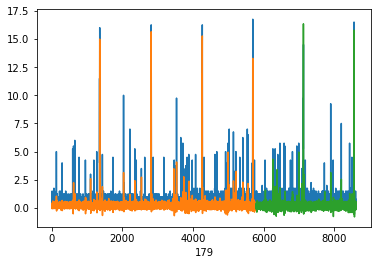

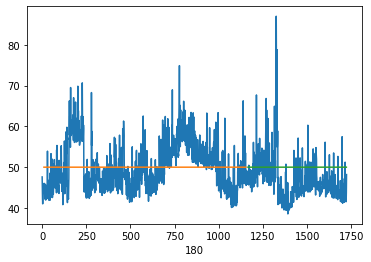

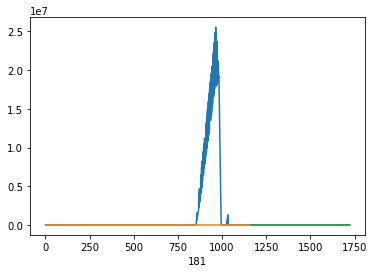

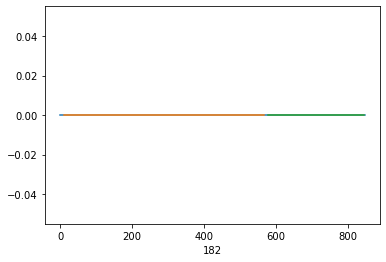

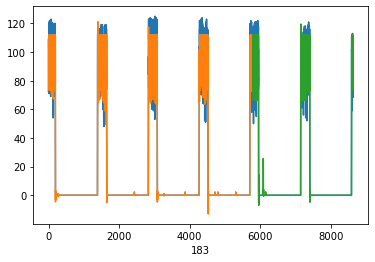

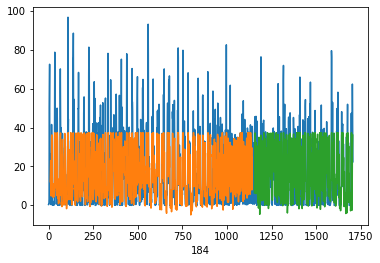

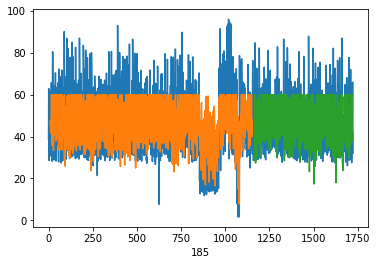

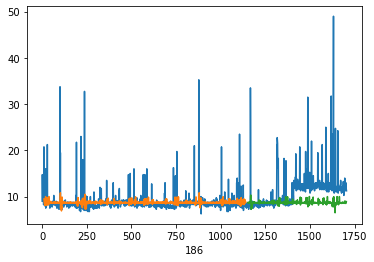

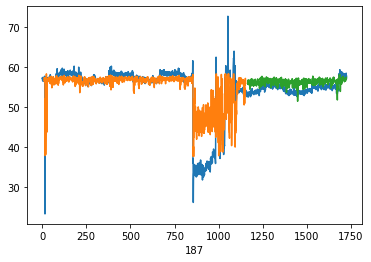

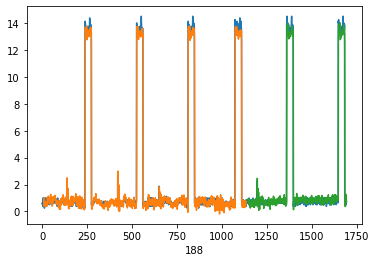

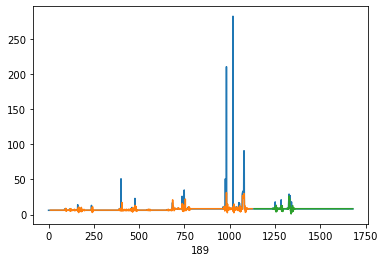

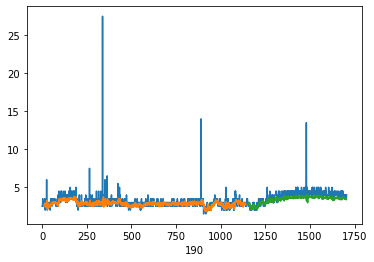

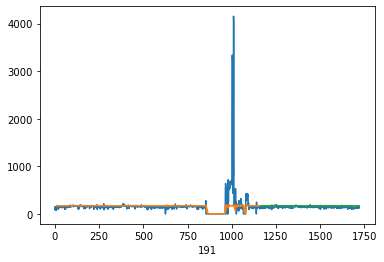

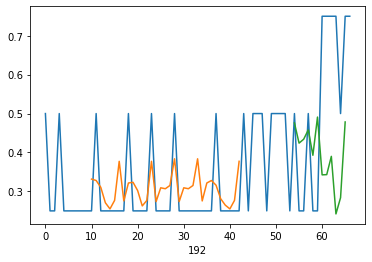

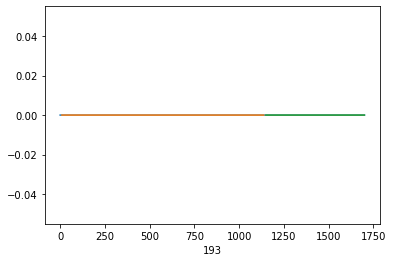

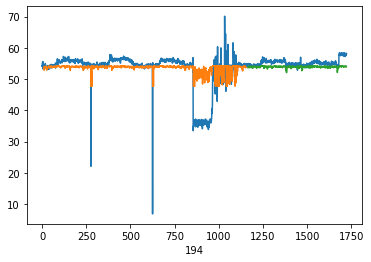

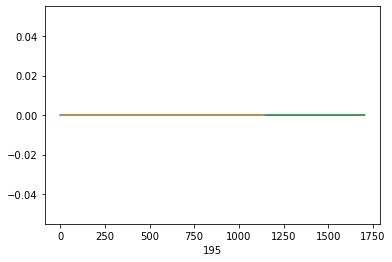

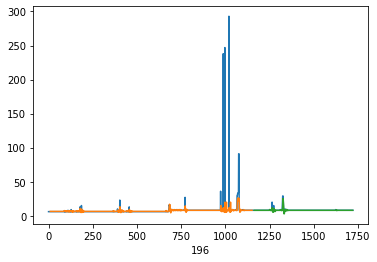

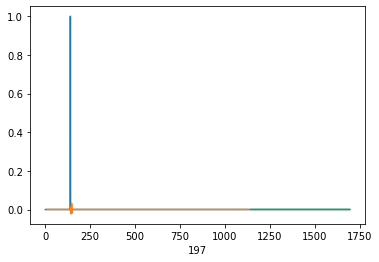

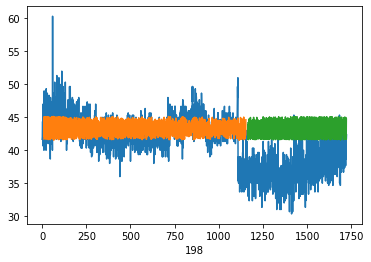

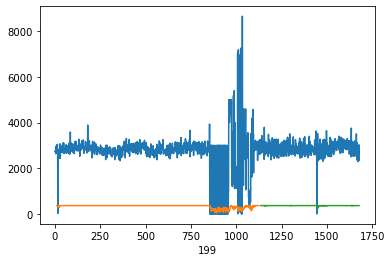

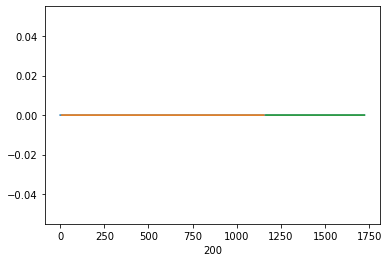

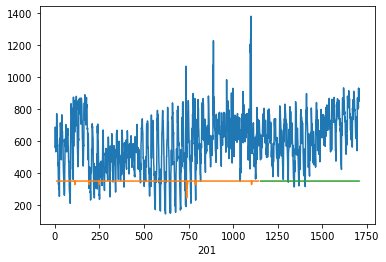

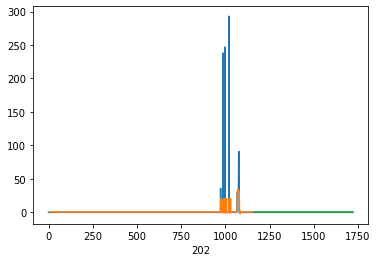

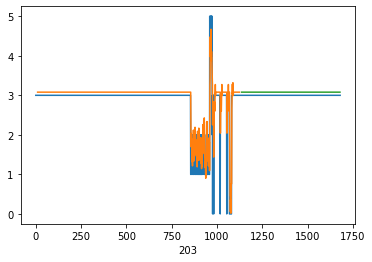

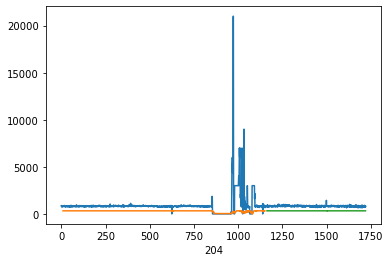

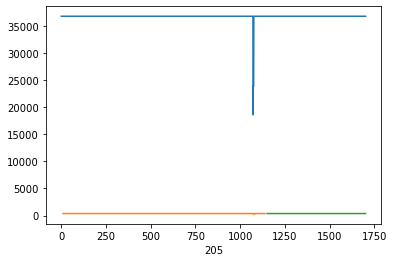

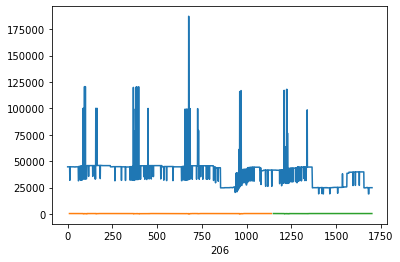

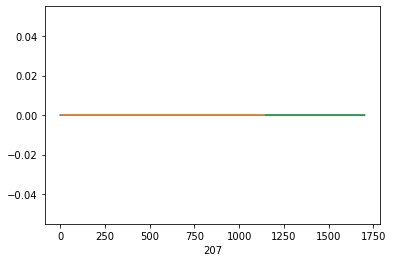

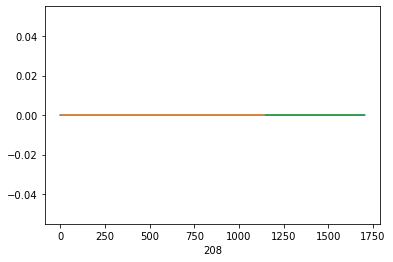

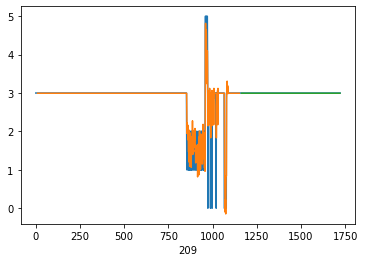

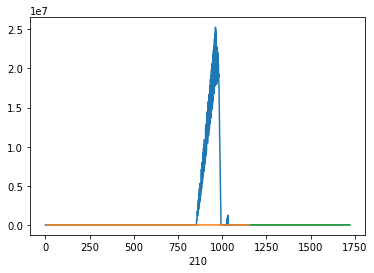

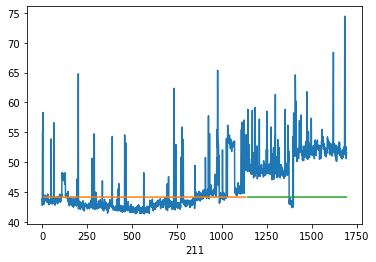

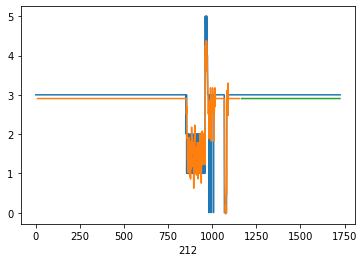

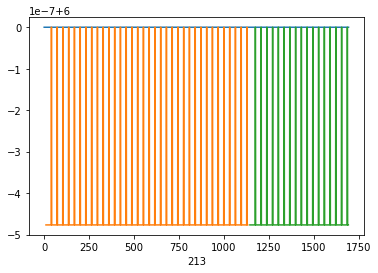

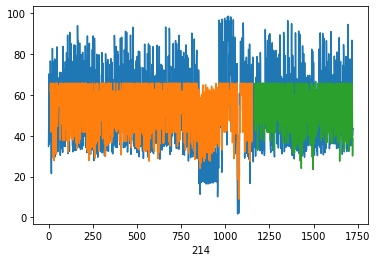

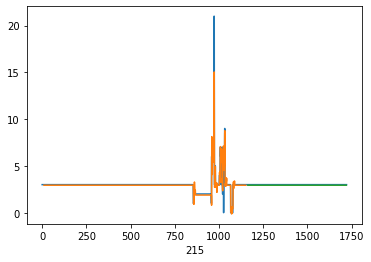

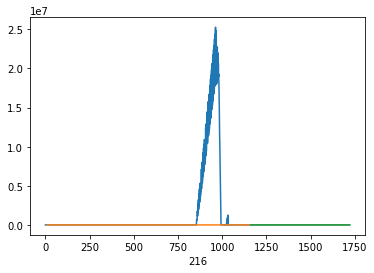

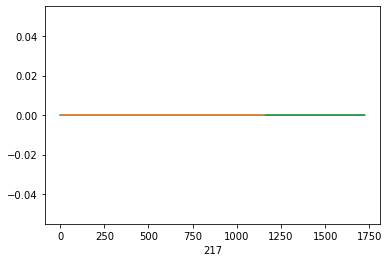

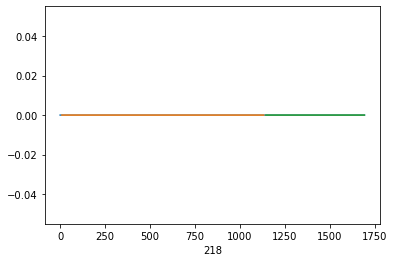

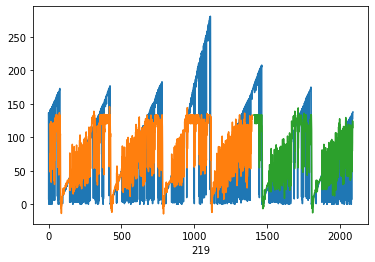

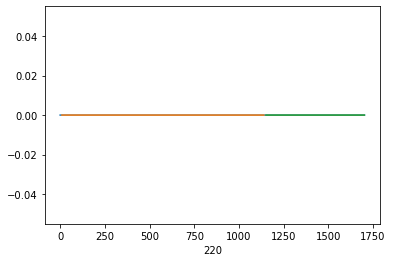

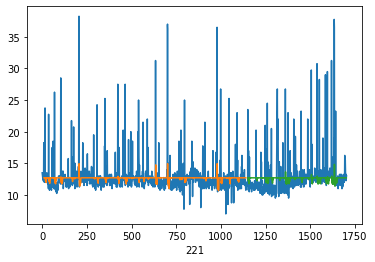

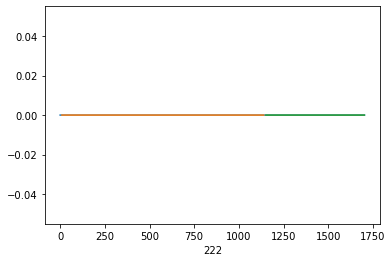

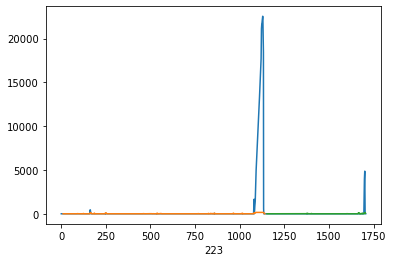

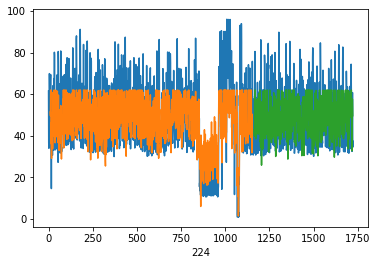

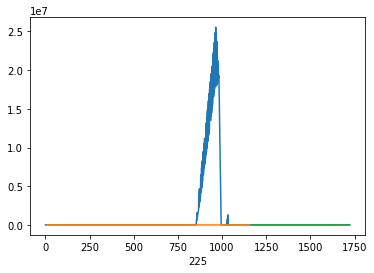

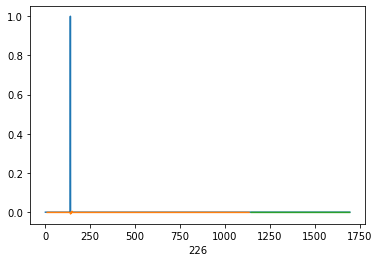

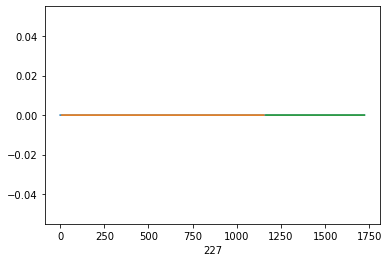

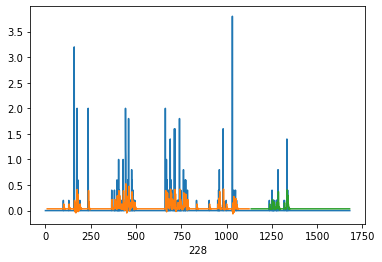

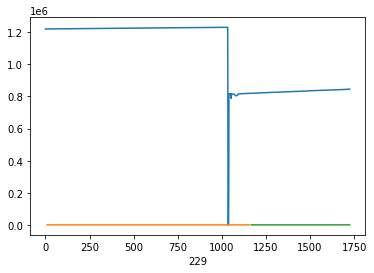

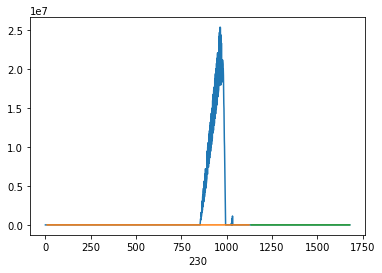

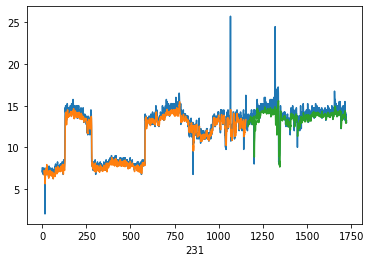

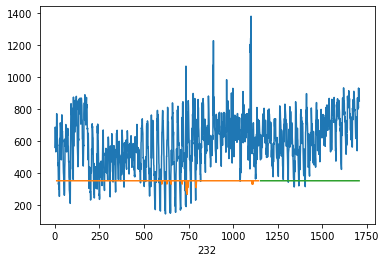

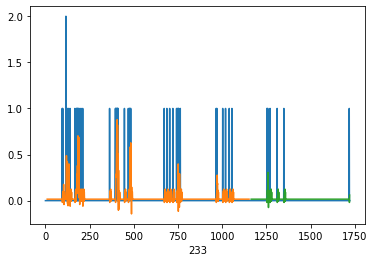

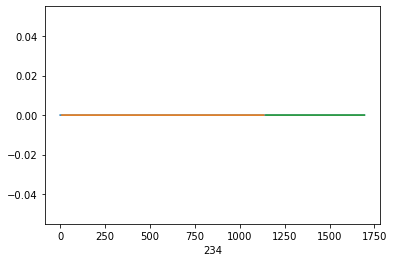

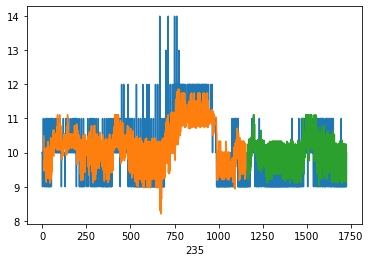

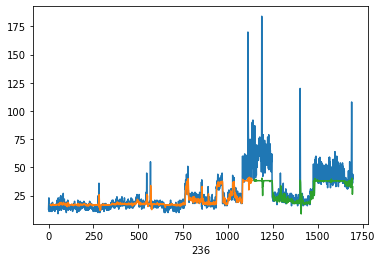

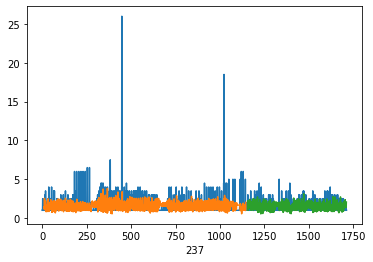

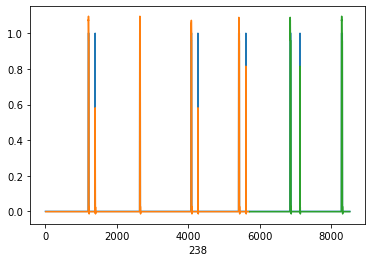

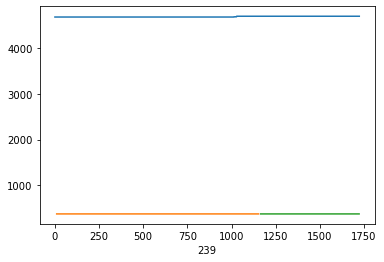

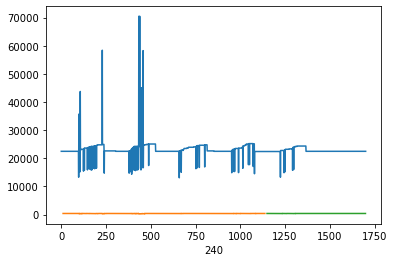

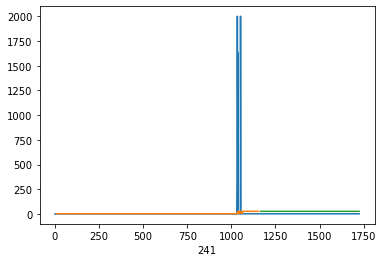

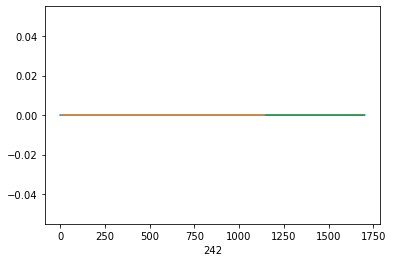

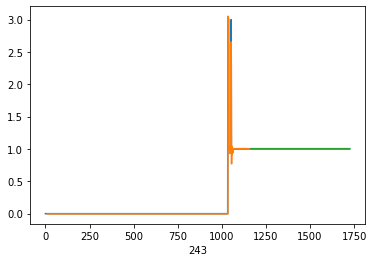

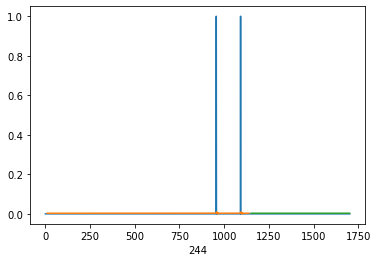

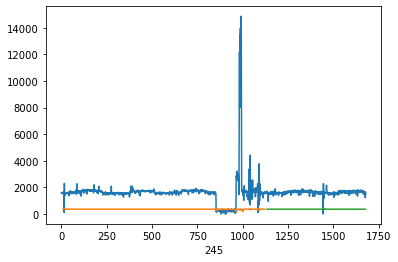

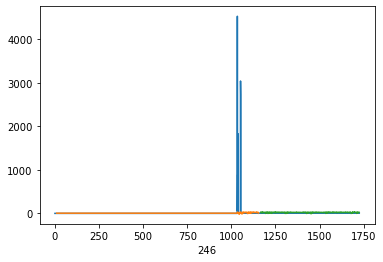

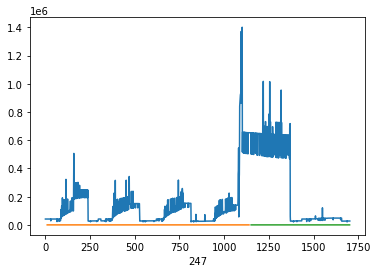

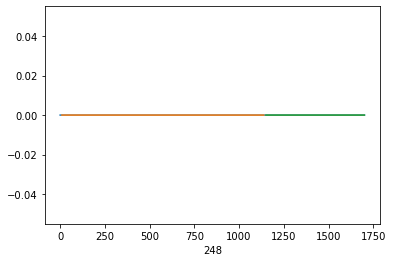

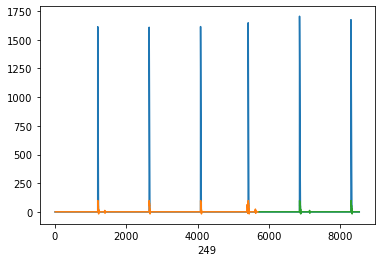

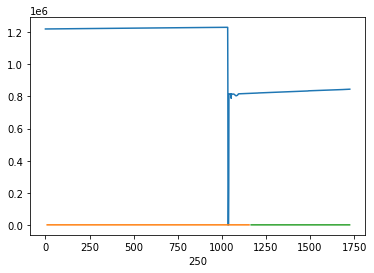

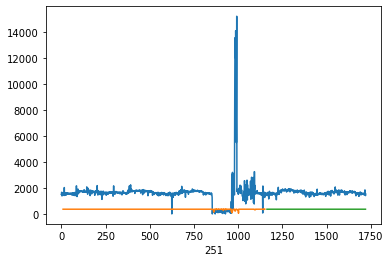

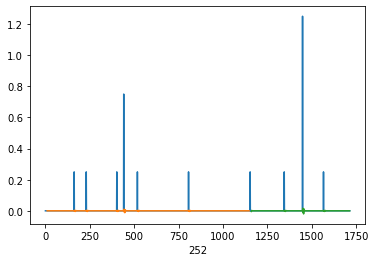

In [5]:
keys_id = list(dic_id.keys())
sample = len(keys_id)
for i in range(sample):
    indx = keys_id[i]
    fig, ax = plt.subplots()
    # shift train predictions for plotting
    trainPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    trainPlot[:, :] = np.nan
    trainPlot[look_back:len(dic_id[indx][3][2])+look_back, :] = dic_id[indx][3][2]
    # shift test predictions for plotting
    validPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    validPlot[:, :] = np.nan
    validPlot[len(dic_id[indx][3][2])+(look_back*2)+1:len(dic_id[indx][1])-1, :] = dic_id[indx][4][2]
    # plot baseline and predictions
    ax.set_xlabel(str(i))
    ax.plot(dic_id[indx][1].reshape(-1,1))
    ax.plot(trainPlot)
    ax.plot(validPlot)
plt.show()